In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import freq_bands_eeg, low_qual_chans

In [2]:
sns.set_theme()

In [4]:
epoch_folder = select_folder("Select the folder that holds sociability experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

2024-04-24 15:23:11.292 python[21351:1292197] +[CATransaction synchronize] called within transaction
2024-04-24 15:23:11.388 python[21351:1292197] +[CATransaction synchronize] called within transaction
2024-04-24 15:23:14.227 python[21351:1292197] +[CATransaction synchronize] called within transaction
2024-04-24 15:23:23.811 python[21351:1292197] +[CATransaction synchronize] called within transaction


## Analysis of one subject
Load the epochs of a test subject

In [5]:
subject_id = 39508
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_{subject_id}-epo.fif"), preload=True)

Let's define the channels we wish to investigate

In [8]:
wanted_chans = [chan for chan in epochs.info['ch_names'] if chan not in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [10]:
print(f'There are {len(epochs)} epochs for subject {subject_id}')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "novel_cup"])} are novel cup interactions epochs')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "familiar_cup"])} are familiar cup interactions epochs')

There are 100 epochs for subject 39508
68 are novel cup interactions epochs
32 are familiar cup interactions epochs


The Epoch Array metadata contains further information on how the epochs were created. Let's take a look.

In [11]:
epochs.metadata

subject_id genotype  interaction_n  interaction_part_n interaction_kind  \
2        39508  DRD2-WT              1                   3        novel_cup   
3        39508  DRD2-WT              1                   4        novel_cup   
4        39508  DRD2-WT              1                   5        novel_cup   
7        39508  DRD2-WT              2                   1        novel_cup   
8        39508  DRD2-WT              2                   2        novel_cup   
..         ...      ...            ...                 ...              ...   
145      39508  DRD2-WT             34                   5        novel_cup   
146      39508  DRD2-WT             35                   1     familiar_cup   
147      39508  DRD2-WT             35                   2     familiar_cup   
149      39508  DRD2-WT             36                   2     familiar_cup   
150      39508  DRD2-WT             36                   3     familiar_cup   

     total_interaction_duration  epoch_length  
2                         6.169           1.0  
3                         6.169           1.0  
4                         6.169           1.0  
7                         4.302           1.0  
8                         4.302           1.0  
..                          ...           ...  
145                       4.734           1.0  
146                       1.667           1.0  
147                       1.667           1.0  
149                       3.935           1.0  
150                       3.935           1.0  

[100 rows x 7 columns]

The metadata contains the interaction identifier. So all rows where *interaction_n* == 1 is data of one single interaction with in this case the novel cup (see *interaction_kind* column).

The *interaction_part_n* tells you something about where along the total interaction duration that specific epoch is located.

### Power Spectral Density (PSD) calculation

In [12]:
df = pd.DataFrame()

for interaction_type in epochs.metadata.interaction_kind.unique():
    
    subject_data = epochs[epochs.metadata["interaction_kind"] == interaction_type]
    subject_id = subject_data.metadata["subject_id"].iloc[0]
    genotype = subject_data.metadata["genotype"].iloc[0]
    
    for channel in wanted_chans:
        # skip plotting data of bad quality
        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            subject_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_data.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]
        
        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
        
        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd (means)": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
            "interaction_kind": interaction_type,
        })])

Let's inspect it a bit

In [13]:
df.head()

freq   psd (means)  psd (norm) subject_id genotype channel interaction_kind
0   0.0  3.194195e-07    0.046953      39508  DRD2-WT   OFC_R        novel_cup
1   1.0  6.394127e-07    0.092847      39508  DRD2-WT   OFC_R        novel_cup
2   2.0  6.331214e-07    0.086653      39508  DRD2-WT   OFC_R        novel_cup
3   3.0  5.766079e-07    0.076237      39508  DRD2-WT   OFC_R        novel_cup
4   4.0  6.008502e-07    0.078242      39508  DRD2-WT   OFC_R        novel_cup

And now we plot the novel cup vs familiar cup powers for all channels. As we're only looking at one subject, we cannot yet compare genotype differences

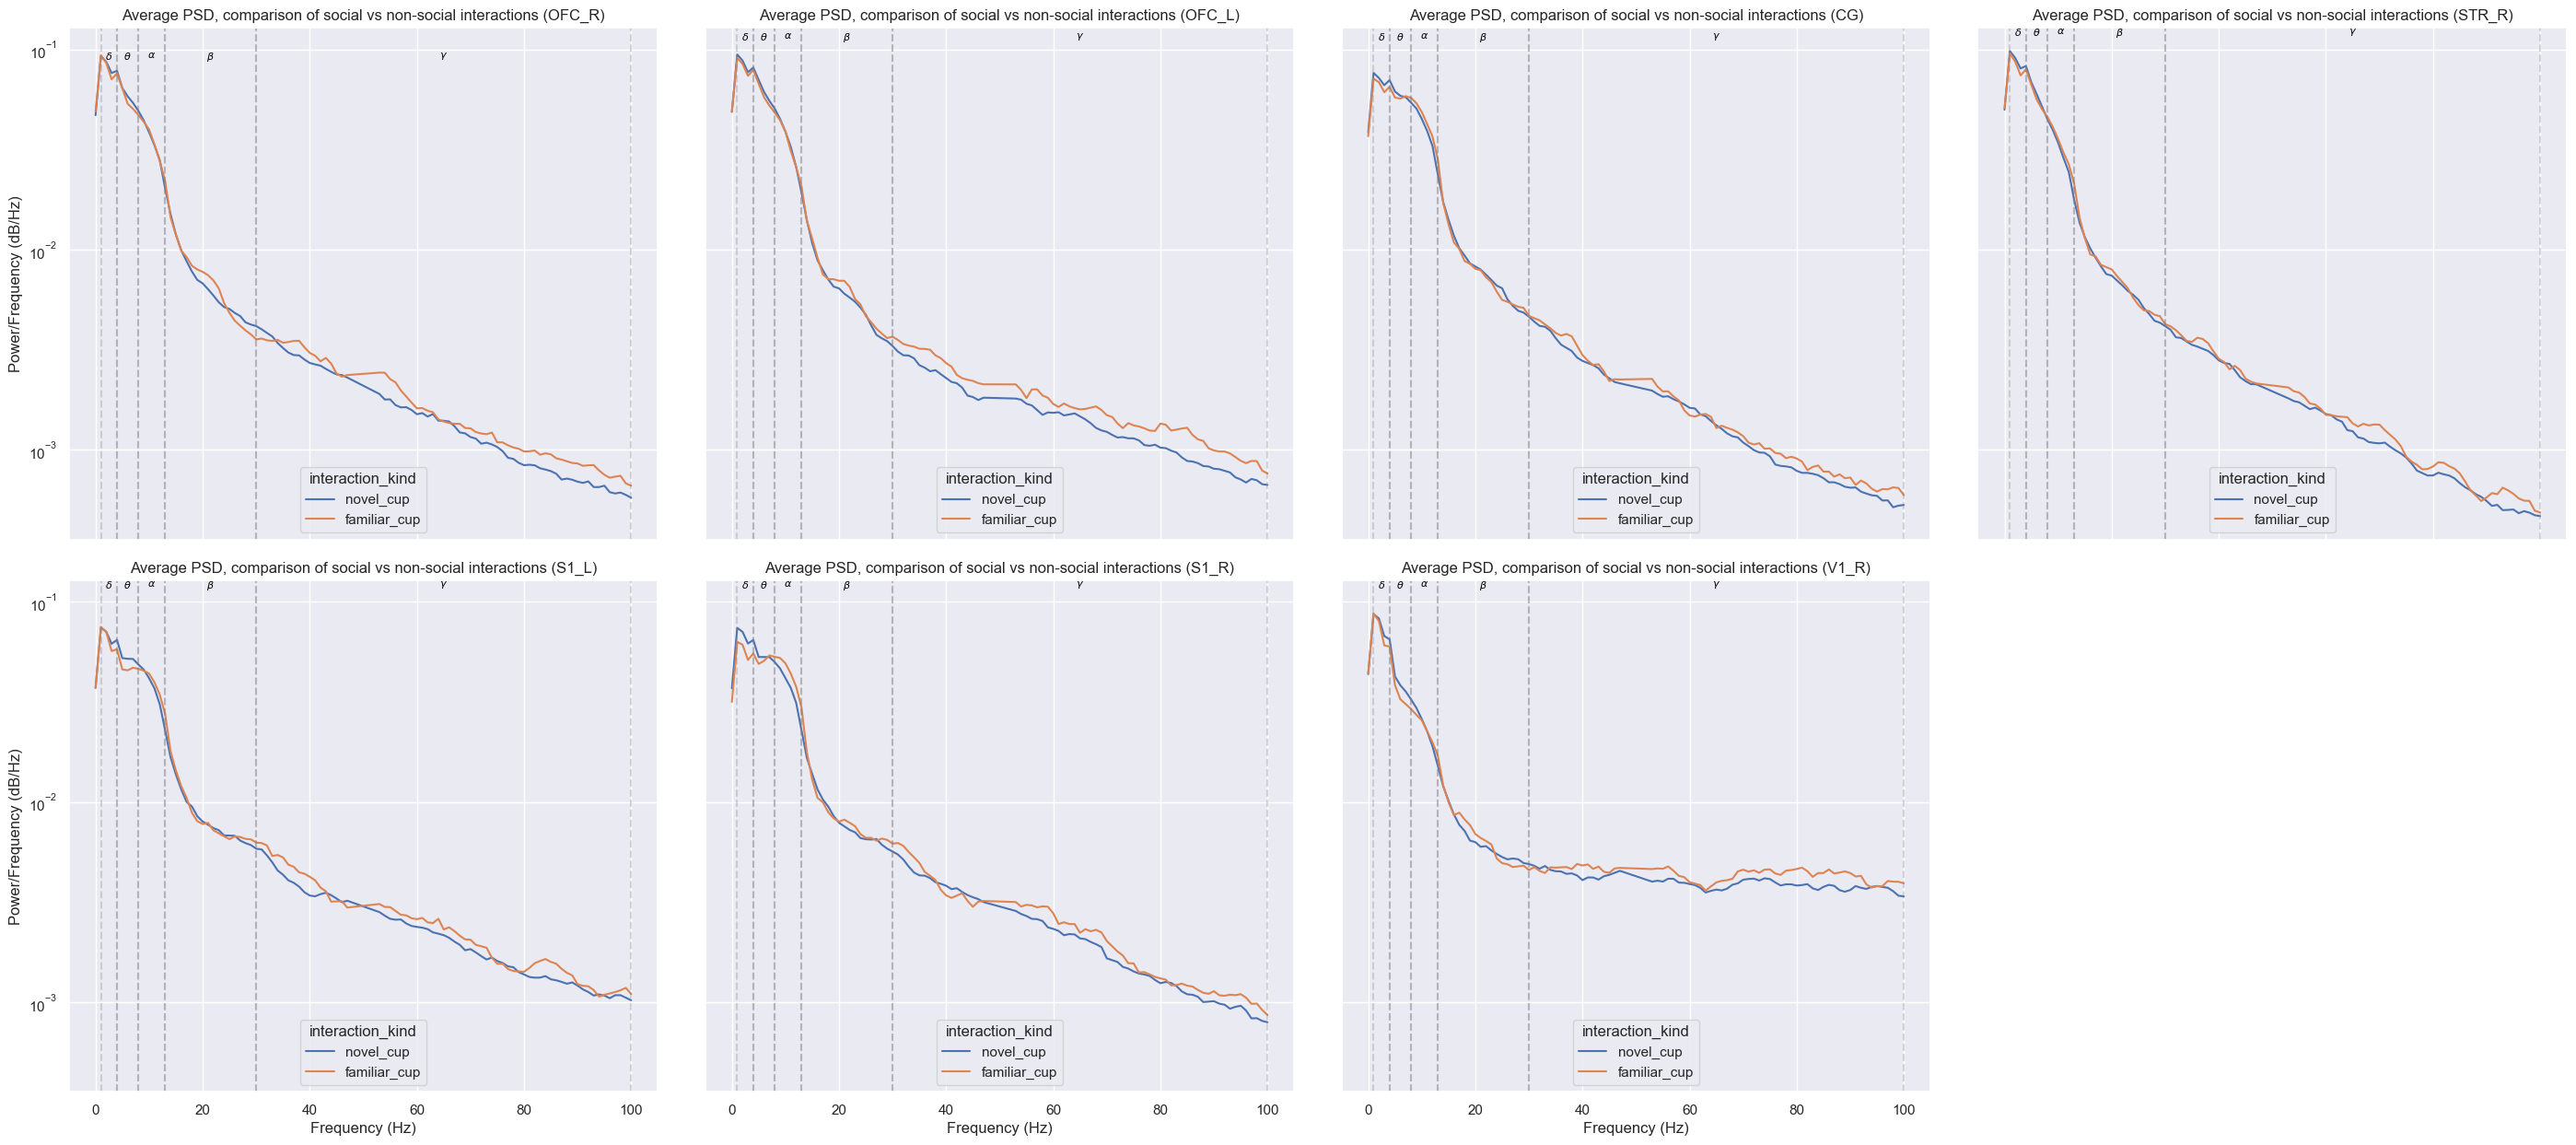

In [14]:
for y_axis in ['psd (norm)']:
    fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
    axs = axs.ravel()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = df[df.channel == channel]
        channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y=y_axis, hue="interaction_kind", legend=True, ax=axs[i], errorbar='se')
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(f'Average PSD, comparison of novel- vs familiar cup interactions ({channel})')
    
    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    axs[-1].remove()
    plt.show()

## Analysis of all subjects

First we load all the epoch files

In [15]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

Let's calculate the PSDs again, but now for all animals

In [16]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]
    
    for interaction_type in subject_epochs.metadata.interaction_kind.unique():
        
        subject_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == interaction_type]
        
        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd (means)": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "interaction_kind": interaction_type,
            })])
        
    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_R for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


Let's check if the dataframe contains what we think it does: all subjects, two types of interactions and the genotypes

In [17]:
print(f'Unique subjects: {df.subject_id.unique()} (n={len(df.subject_id.unique())})')
print(f'The genotypes: {[df[df.subject_id == subject_id].genotype.iloc[0] for subject_id in df.subject_id.unique()]}')
print(f'Unique interactions: {df.interaction_kind.unique()}')

Unique subjects: ['80625' '81175' '39489' '79604' '81218' '78233' '81193' '78244' '79592'
 '79593' '78211' '78227' '81217' '81207' '80630' '80620' '39508' '79602'] (n=18)
The genotypes: ['DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-WT', 'DRD2-KO', 'DRD2-WT', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT']
Unique interactions: ['novel_cup' 'familiar_cup']


So there are 9 KOs and 8 WTs

First, let's make an overview grid plot of each subjects PSDs per channel

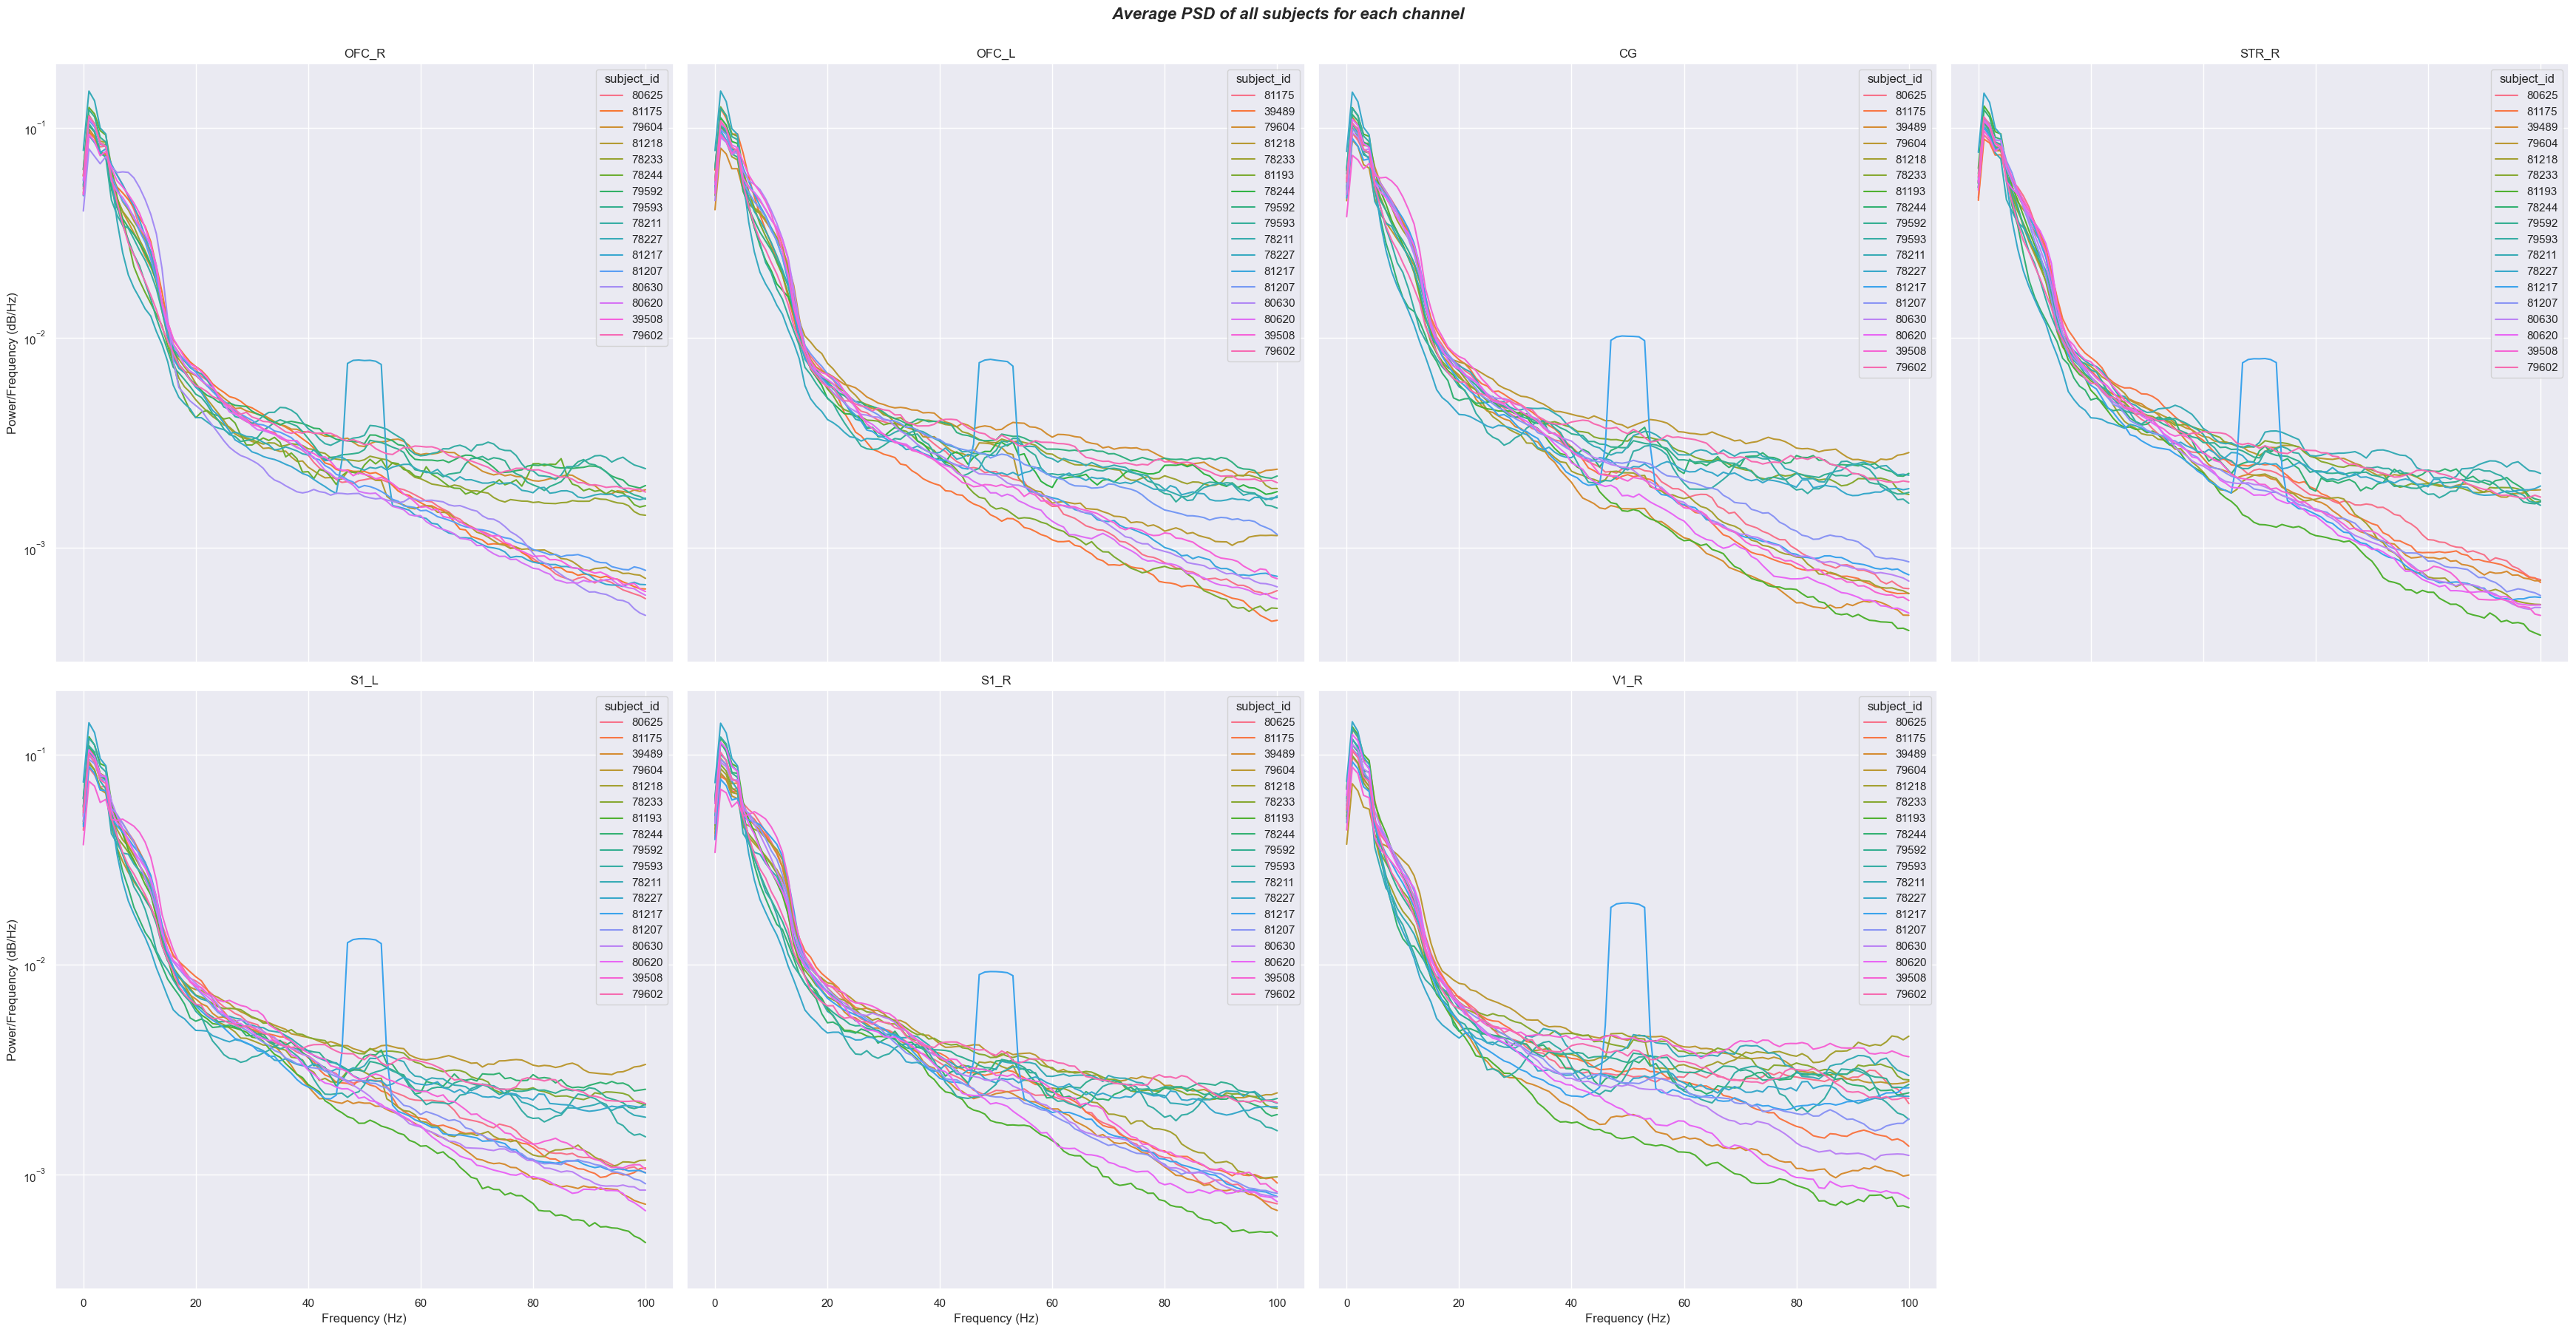

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average PSD of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

81217 looks quite ugly, let's remove that one for now. 

We proceed with creating a grid plot that holds a subplot for each channel that displays the average power of the two different kinds of interactions

In [19]:
df = df[df.subject_id != '81217']
df.subject_id.unique()

array(['80625', '81175', '39489', '79604', '81218', '78233', '81193',
       '78244', '79592', '79593', '78211', '78227', '81207', '80630',
       '80620', '39508', '79602'], dtype=object)

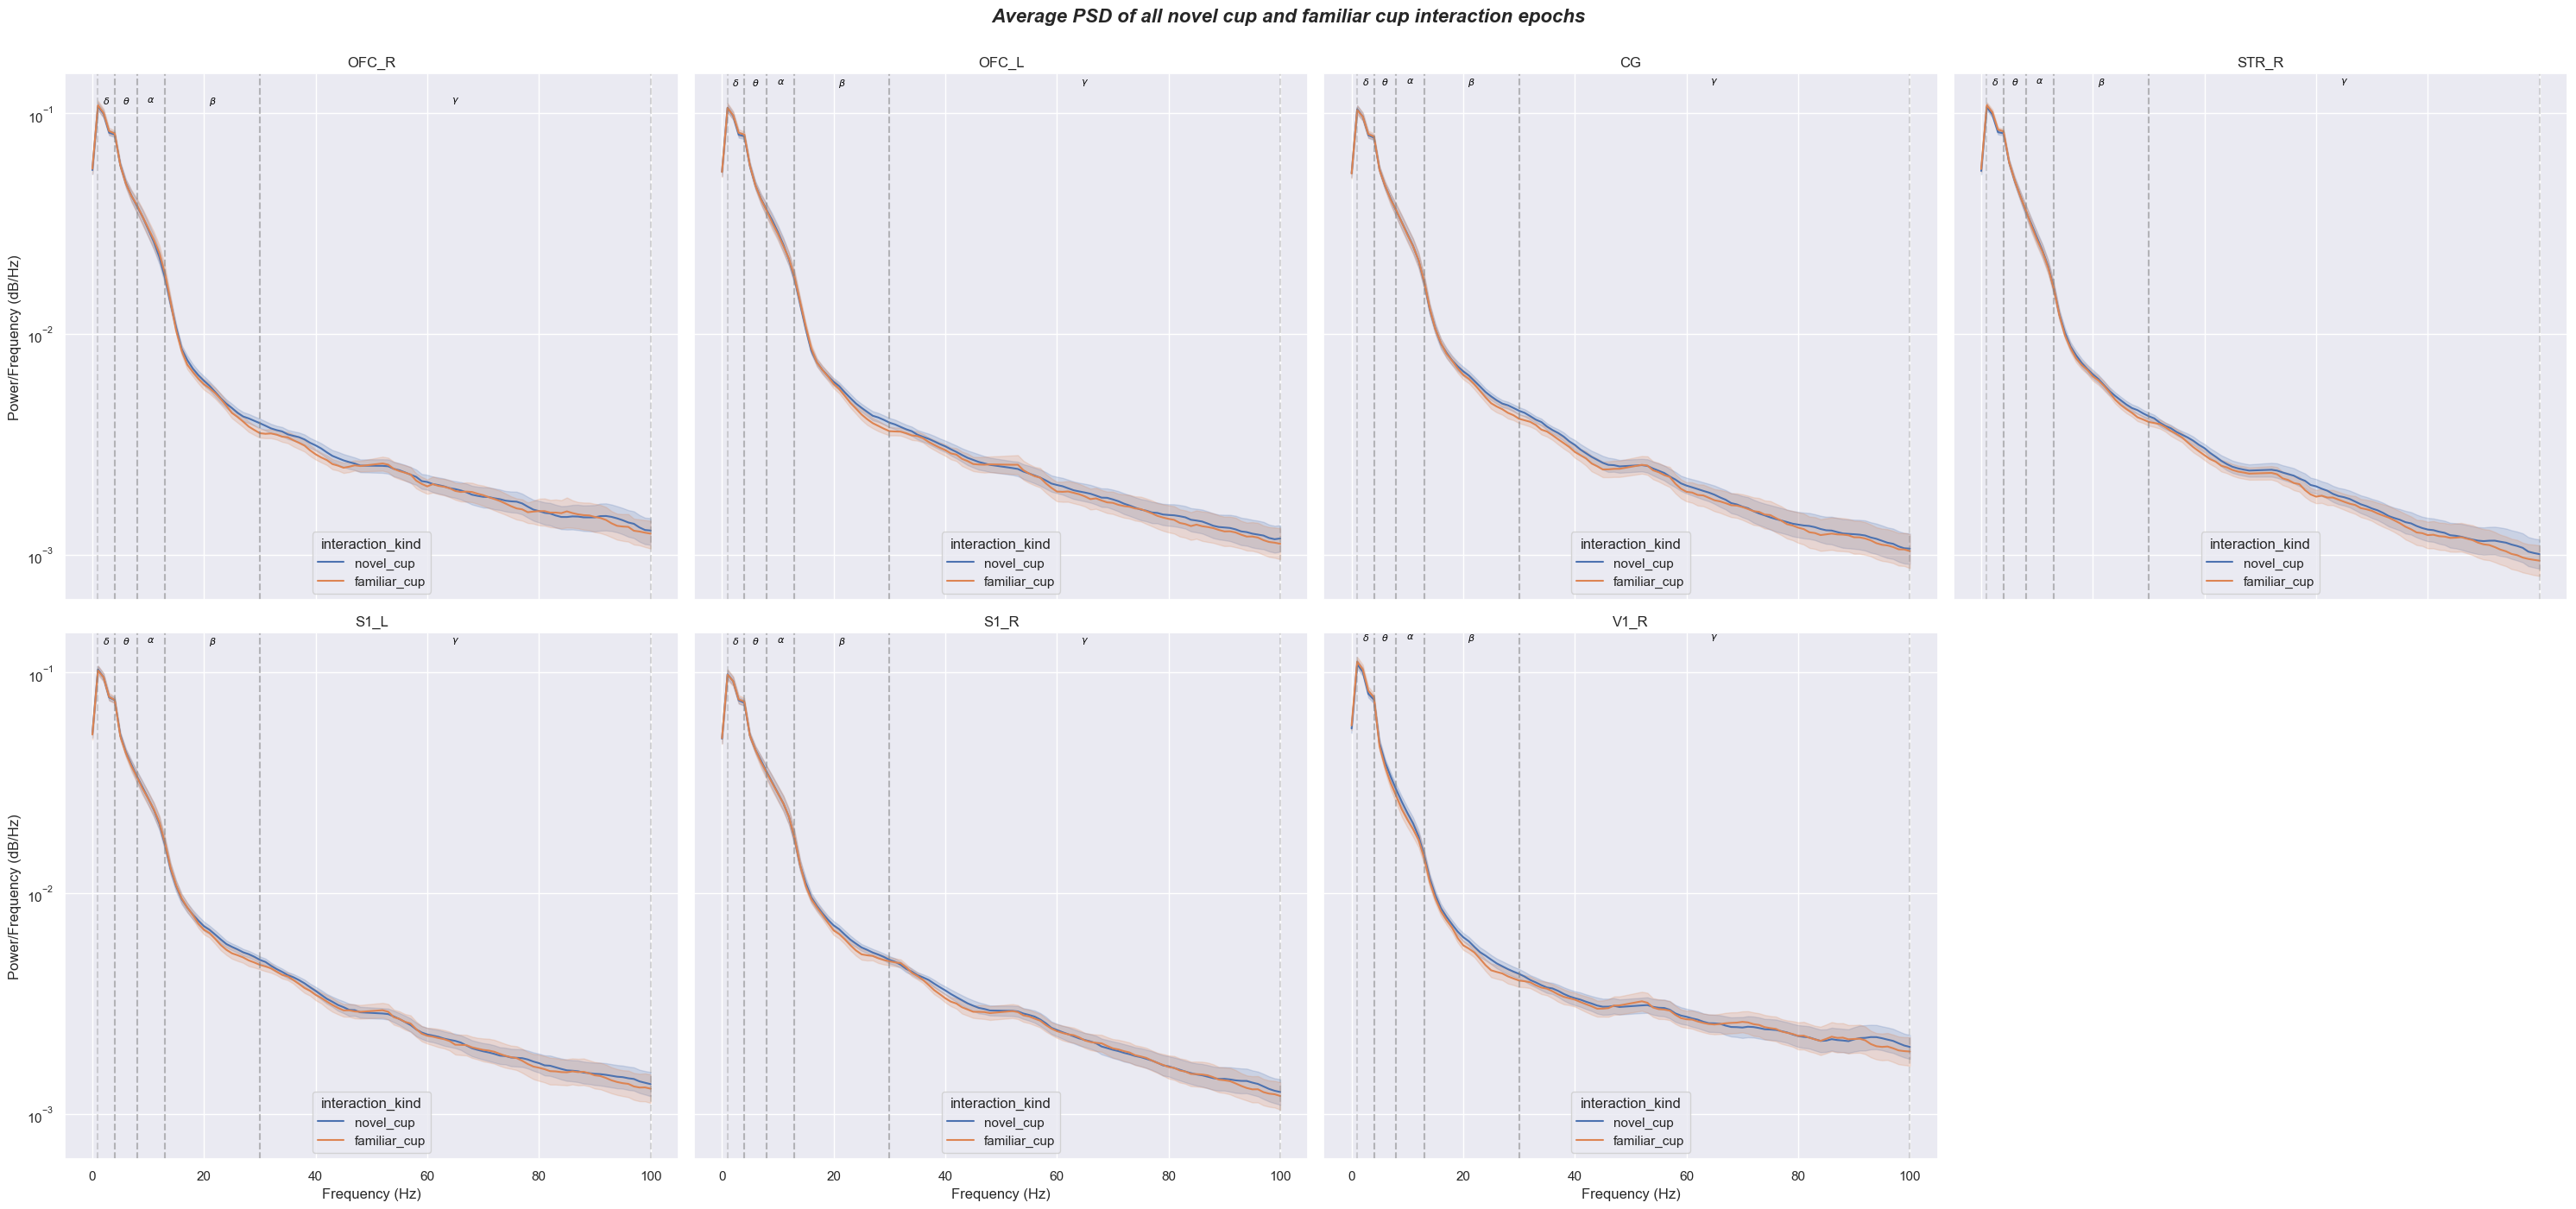

In [20]:
for y_axis in ['psd (norm)']:
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = df[df.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y=y_axis, hue="interaction_kind", legend=True, ax=axs[i], errorbar='se')
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
    
    plt.suptitle(
        'Average PSD of all novel cup and familiar cup interaction epochs',
        fontsize=16, fontweight='bold', fontstyle='italic', y=1
    )
    plt.tight_layout()
    axs[-1].remove()
    plt.show()

Now plot the normalized PSDs per interaction type and hue also on genotype

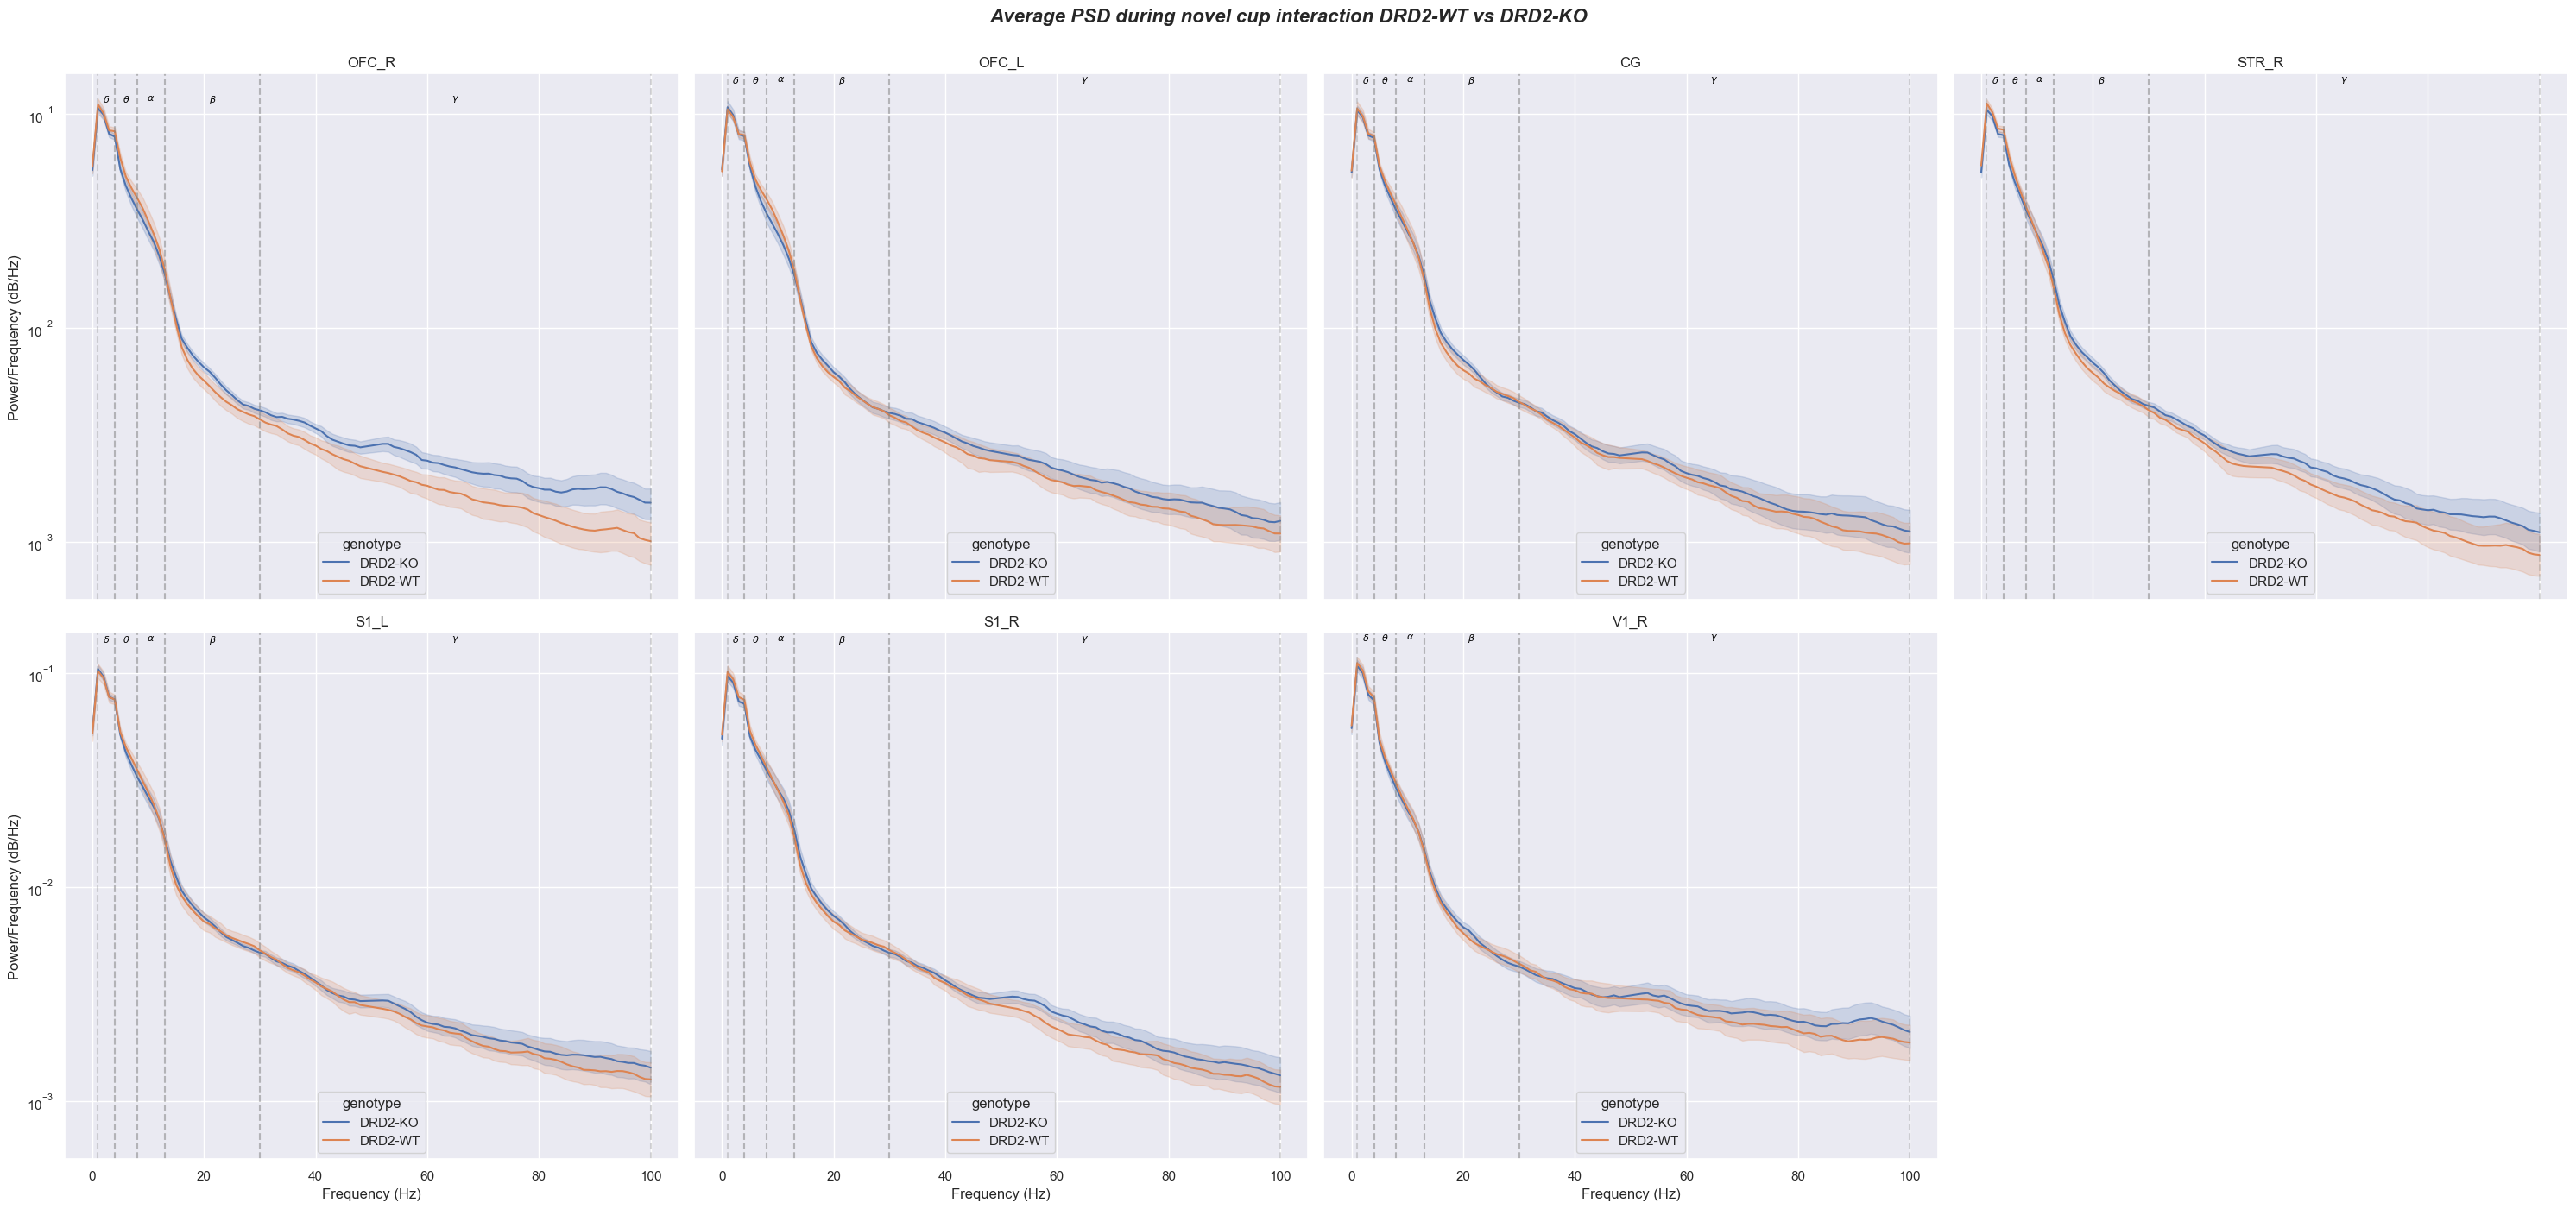

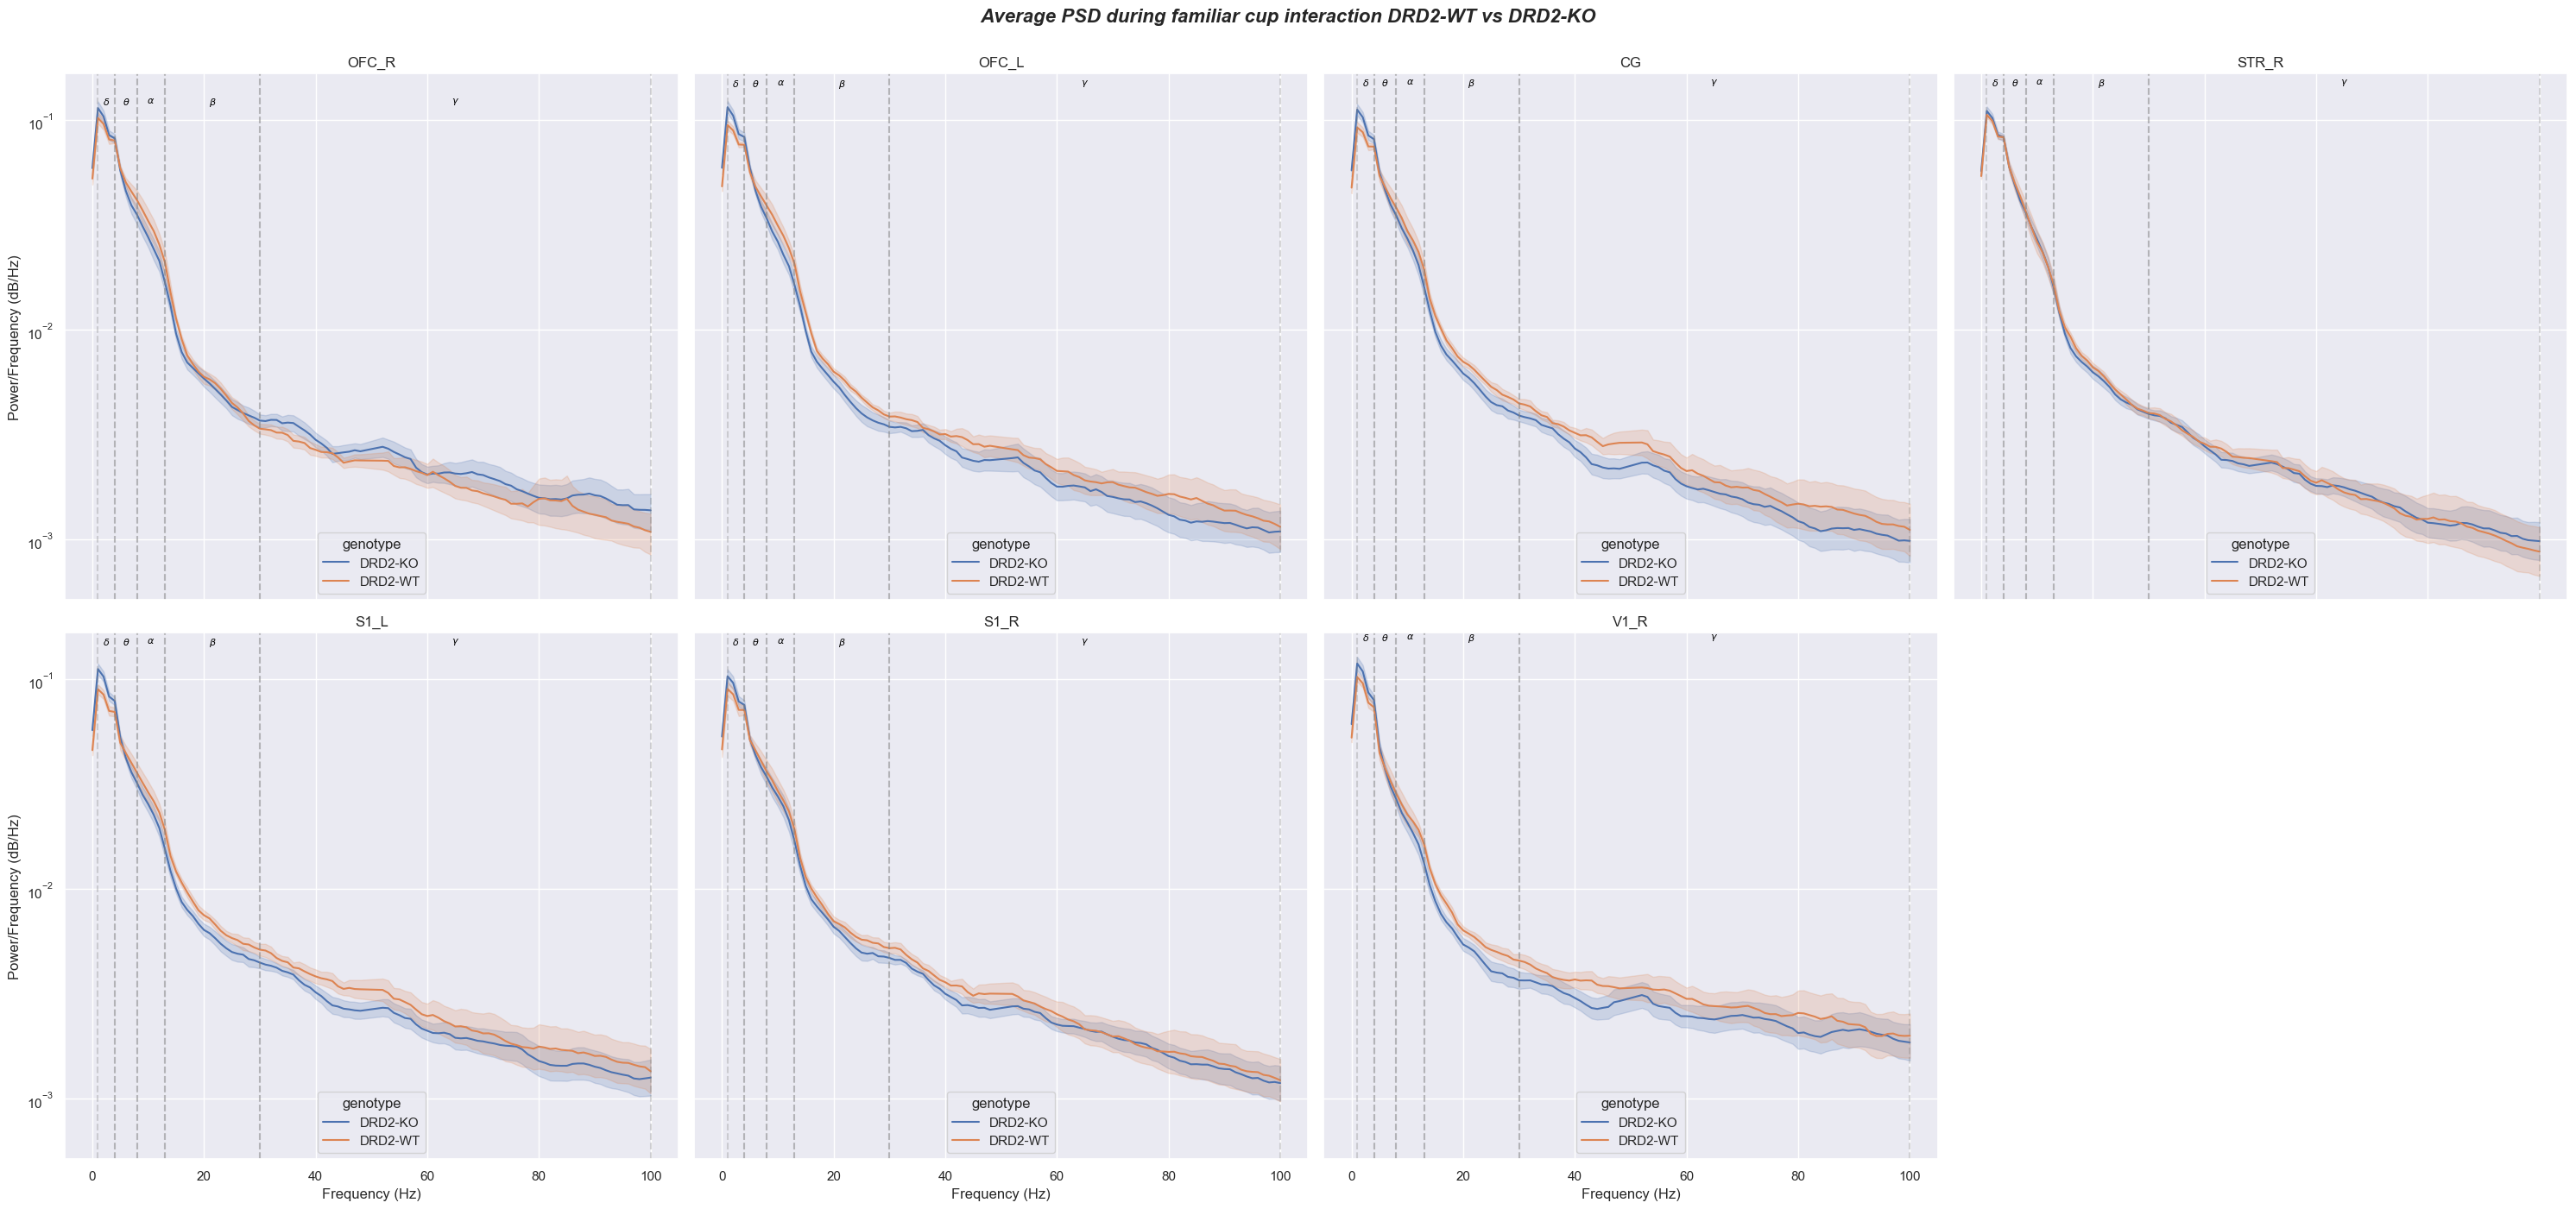

In [21]:
for y_axis in ['psd (norm)']:

    for interaction_kind in df.interaction_kind.unique():
        
        fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
        axs = axs.ravel()
        
        interaction_data = df[df.interaction_kind == interaction_kind]
        
        for i, channel in enumerate(wanted_chans):
            
            channel_data = interaction_data[interaction_data.channel == channel]
            channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
            
            sns.lineplot(data=channel_data, x='freq', y=y_axis, hue="genotype", legend=True, ax=axs[i], errorbar='se')
            
            for band, (start, end) in freq_bands_eeg.items():
                axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
                axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
                axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
            
            axs[i].set_yscale('log')
            axs[i].set_xlabel('Frequency (Hz)')
            axs[i].set_ylabel('Power/Frequency (dB/Hz)')
            axs[i].set_title(channel)
            
        plt.suptitle(f'Average PSD during {"familiar cup interaction" if interaction_kind == "familiar_cup" else "novel cup interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
        plt.tight_layout()
        axs[-1].remove()
        plt.show()

There doesn't seem to be a difference in power when comparing novel- to familiar cup interactions for either genotype

Now, we calculate a ratio between the novel- and familiar-cup powers per subjects, and then take the average of those ratios per genotype.

In [23]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    if subject_epochs.metadata.subject_id.iloc[0] == '81217':
        print('Skipping 81217')
        continue
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]

    novel_cup_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == "novel_cup"]
    familiar_cup_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == "familiar_cup"]
    
    for channel in wanted_chans:

        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            novel_cup_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_epochs.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        mean_psd_sub_novel = np.mean(psds_sub[:, 0, :], axis=0)
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            familiar_cup_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_epochs.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        mean_psd_sub_familiar = np.mean(psds_sub[:, 0, :], axis=0)
       
        novel_over_familiar_psd_ratio = mean_psd_sub_novel / mean_psd_sub_familiar

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd_ratio": novel_over_familiar_psd_ratio,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
        })])

    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Skipping 81217
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


In [24]:
df

freq  psd_ratio subject_id genotype channel
0      0.0   2.459065      80625  DRD2-KO   OFC_R
1      1.0   2.495242      80625  DRD2-KO   OFC_R
2      2.0   2.505553      80625  DRD2-KO   OFC_R
3      3.0   2.519876      80625  DRD2-KO   OFC_R
4      4.0   2.442829      80625  DRD2-KO   OFC_R
..     ...        ...        ...      ...     ...
96    96.0   1.375108      79602  DRD2-WT    V1_R
97    97.0   1.465661      79602  DRD2-WT    V1_R
98    98.0   1.292594      79602  DRD2-WT    V1_R
99    99.0   1.365835      79602  DRD2-WT    V1_R
100  100.0   1.303852      79602  DRD2-WT    V1_R

[11716 rows x 5 columns]

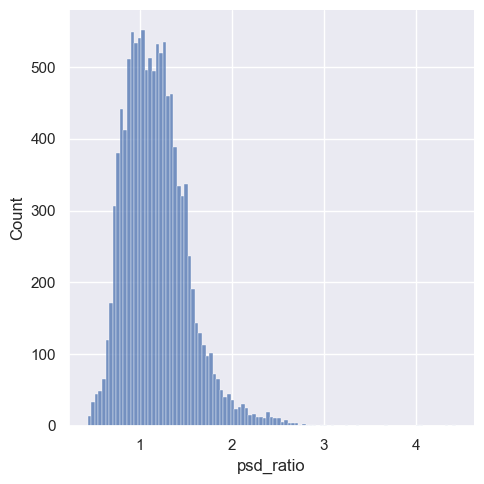

In [25]:
sns.displot(df.psd_ratio)
plt.show()

Remove outlier ratios based on IQR method

In [26]:
Q1 = np.percentile(df.psd_ratio, 25)
Q3 = np.percentile(df.psd_ratio, 75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['psd_ratio'] >= lower_bound) & (df['psd_ratio'] <= upper_bound)]

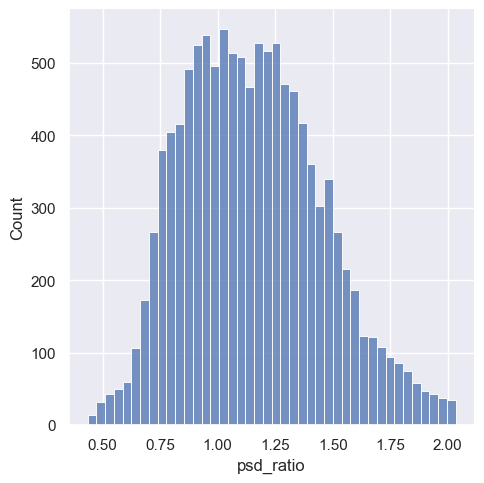

In [27]:
sns.displot(df.psd_ratio)
plt.show()

Now that the outliers are gone, we plot the averaged novel cup over familiar cup power ratios of all subjects of the two genotypes.

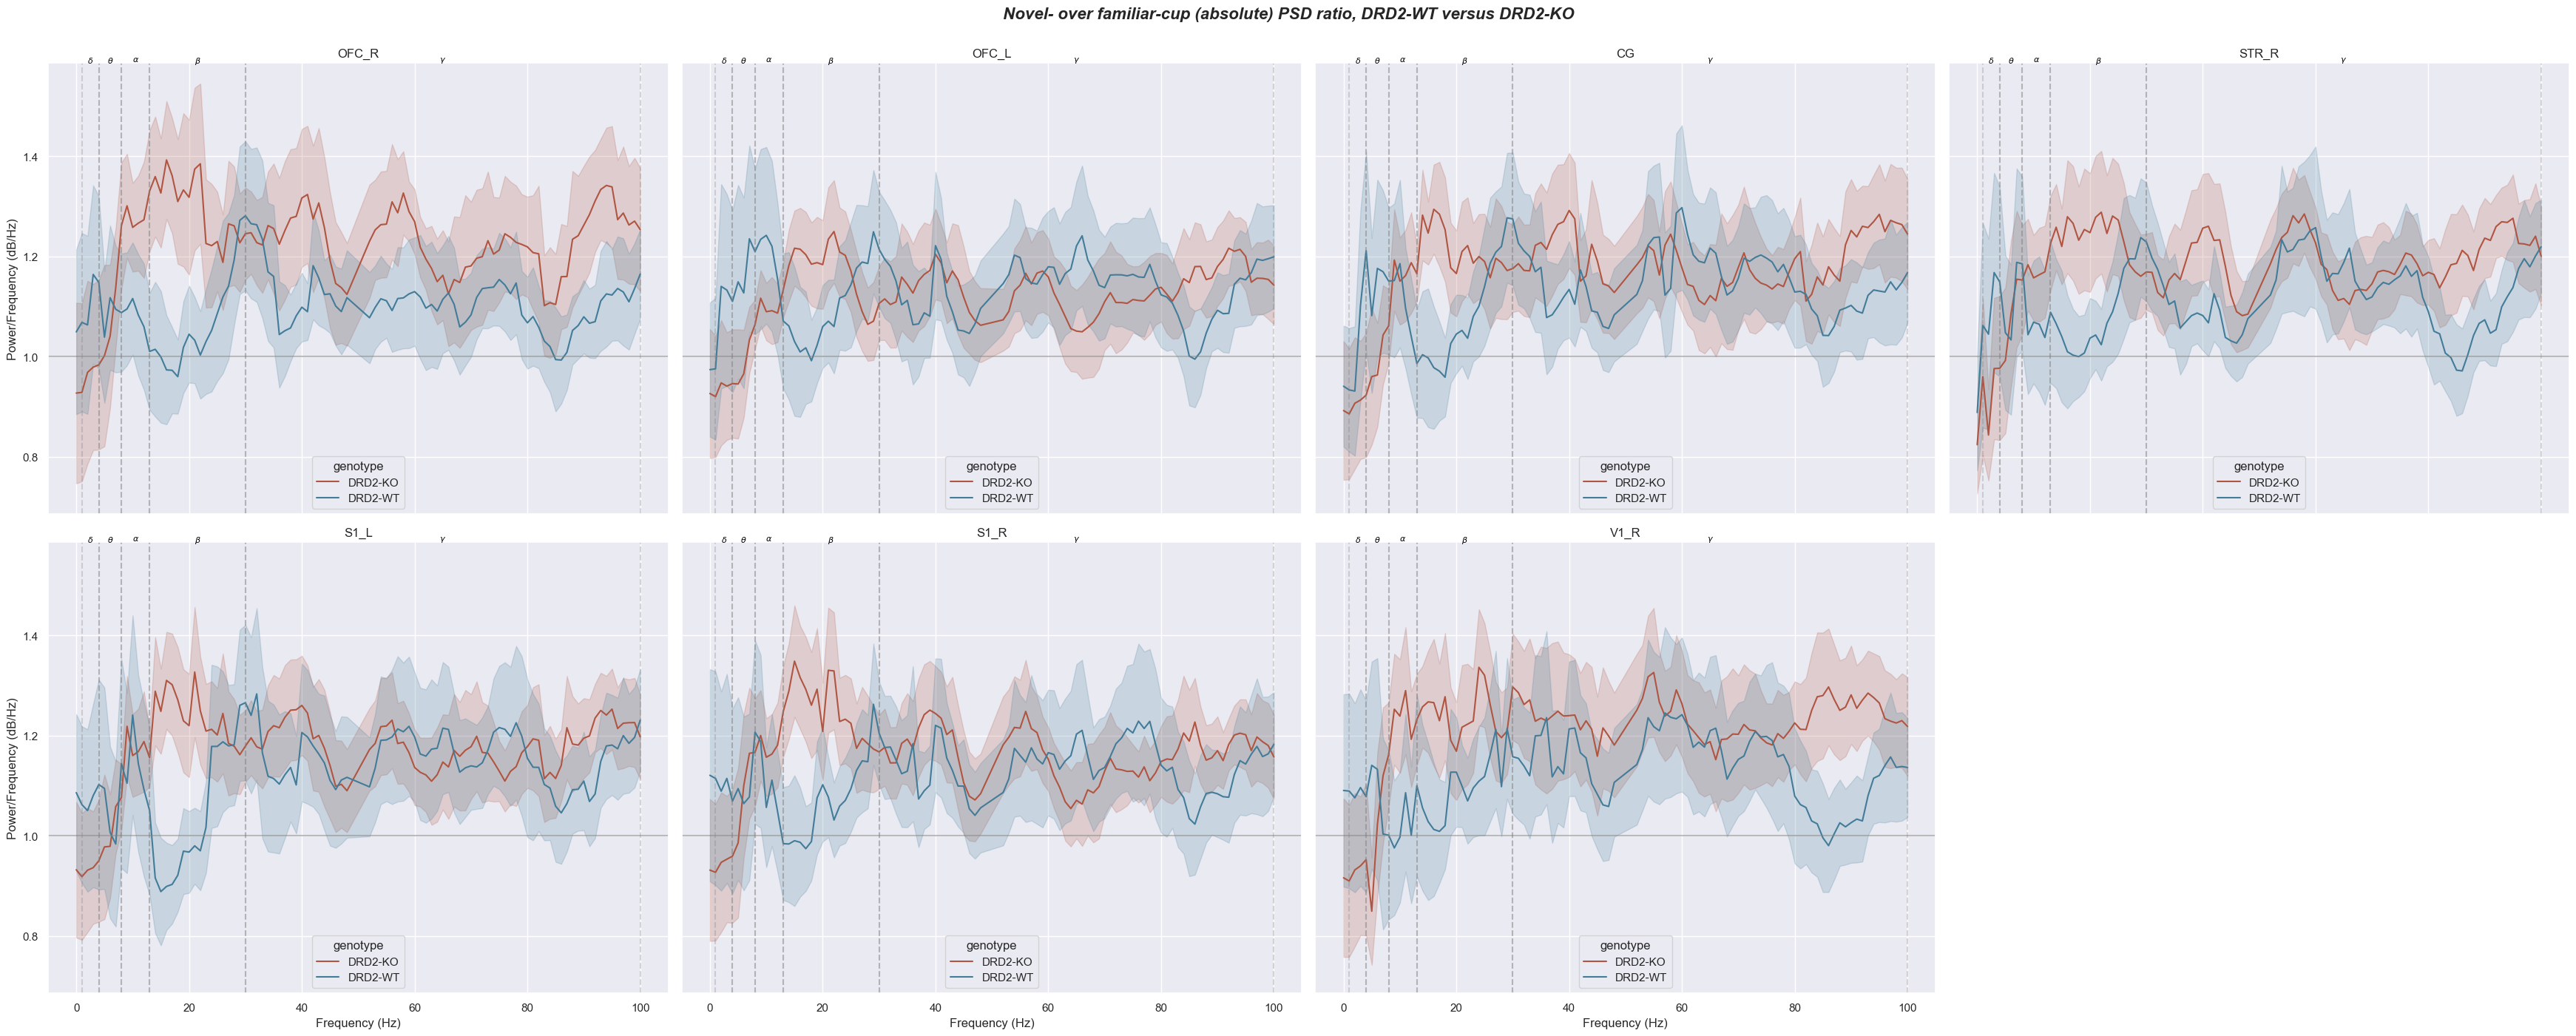

In [29]:
for y_axis in ['psd_ratio']:
    fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = df[df.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
        sns.lineplot(data=channel_data, x='freq', y=y_axis, hue="genotype", legend=True, ax=axs[i], errorbar='se', palette=palette)
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
            
        axs[i].axhline(y=1, linestyle='-', alpha=.5, color='gray')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(f'{channel}')
    
    plt.suptitle(
        "Novel- over familiar-cup (absolute) PSD ratio, DRD2-WT versus DRD2-KO", 
        fontsize=16, fontweight='bold', fontstyle='italic', y=1
    )
    plt.tight_layout()
    axs[-1].remove()
    plt.show()

It seems like the major thing to note here is that the ratio of novel over familiar power is higher in the KOs in the alpha and beta bands.

TODO:
- Tag bad epochs manually using older version of MNE
- Maybe rurun everything, but with resampling to 1000 Hz instead of 500 Hz